#### Correlation between Wage, Sector and Occupation under Different States

We would like to understand what's the correlation between the three key factors: wage, sector and occupation. We use three states as example here, which are CA, NY and IL. Below are the codes:

In [3]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
# Read in the data
myiterator = pd.read_csv('H-1B_Disclosure_Data_FY17_update.csv', dtype=object, iterator=True, index_col=False, chunksize=100000)
rawdata = pd.concat(myiterator, ignore_index=True)
# get required columns and only H1B data
rawdata = rawdata[rawdata['VISA_CLASS']=='H-1B']
# print rawdata.shape
# get yearly pay only
rawdata = rawdata[rawdata['WAGE_UNIT_OF_PAY']=='Year'][['WAGE_RATE_OF_PAY_FROM','JOB_TITLE','SOC_CODE','SOC_NAME','NAICS_CODE','WORKSITE_STATE']]

In [5]:
# to clean/mark wrong SOC_CODE and NAICS_CODE for deletion
cleanSOC = rawdata['SOC_CODE'].str.replace('-','').map(lambda x: str(x)[0:6] if x.isdigit() else '000000')
cleanNAICS = rawdata['NAICS_CODE'].map(lambda x: str(x).ljust(6,'0') if str(x) !='nan' else '000000')
cleandata = rawdata.copy()
cleandata['SOC_CODE'], cleandata['NAICS_CODE']  = cleanSOC, cleanNAICS

In [6]:
# Get the states corressponding data
states = ['CA','NY','IL']#,'TX','NY','NJ','IL','MA','WA','GA','FL','PA']
cleandataStates = cleandata.loc[cleandata['WORKSITE_STATE'].isin(states)]
cleandataStates['WORKSITE_NUM'] = cleandataStates['WORKSITE_STATE'].map(lambda x: states.index(x)+1)
cleandataStates.shape
# for cluster data selection
dataCluster = cleandataStates[['WAGE_RATE_OF_PAY_FROM','NAICS_CODE','SOC_CODE', 'WORKSITE_NUM']]
dataCluster['WAGE_RATE_OF_PAY_FROM'] = dataCluster['WAGE_RATE_OF_PAY_FROM'].str.replace(',', '')
# delete away the wrong input for NAICS_CODE and SOC_CODE
dataCluster = dataCluster[(dataCluster['SOC_CODE']!='000000') & (dataCluster['NAICS_CODE']!='000000')]
# sort the NAICS_CODE and SOC_CODE
dataCluster = dataCluster.apply(pd.to_numeric)
# get away the extreme in salary
dataCluster = dataCluster[dataCluster['WAGE_RATE_OF_PAY_FROM']<200000]
# use index for axis numbering & get away the wrong number
dataCluster = dataCluster.sort_values('NAICS_CODE').reset_index(drop=True).loc[3:]
# create sorted_index (repetition means the same)
i, naics, lastrow = 0, [], dataCluster['NAICS_CODE'].iloc[0]
for row in dataCluster['NAICS_CODE']:
    if row != lastrow:
        i += 1
        naics.append(i)
    else:
        naics.append(i)
    lastrow = row
dataCluster['naics'] = pd.Series(naics).values
dataCluster = dataCluster.sort_values('SOC_CODE').reset_index(drop=True).loc[2:]
i, soc, lastrow = 0, [], dataCluster['SOC_CODE'].iloc[0]
for row in dataCluster['SOC_CODE']:
    if row != lastrow:
        soc.append(i)
        i += 1
    else:
        soc.append(i)
    lastrow = row
dataCluster['soc'] = pd.Series(soc).values
myCluster = dataCluster[['WAGE_RATE_OF_PAY_FROM','naics','soc','WORKSITE_NUM', 'SOC_CODE']]
# get the wage in unit thousand, for least-square cluster scaling issue
myCluster['WAGE_RATE_OF_PAY_FROM'] = dataCluster['WAGE_RATE_OF_PAY_FROM']/1000

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [5]:
# get data for each of the states
myClusterCA = myCluster[myCluster['WORKSITE_NUM']==1][['WAGE_RATE_OF_PAY_FROM','naics','soc','SOC_CODE']]
myClusterNY = myCluster[myCluster['WORKSITE_NUM']==2][['WAGE_RATE_OF_PAY_FROM','naics','soc','SOC_CODE']]
myClusterIL = myCluster[myCluster['WORKSITE_NUM']==3][['WAGE_RATE_OF_PAY_FROM','naics','soc','SOC_CODE']]

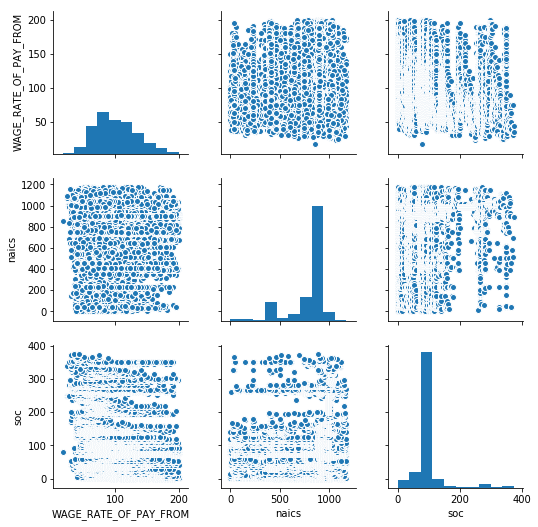

In [6]:
# plot data for California
ca = sns.pairplot(myClusterCA[['WAGE_RATE_OF_PAY_FROM','naics','soc']])

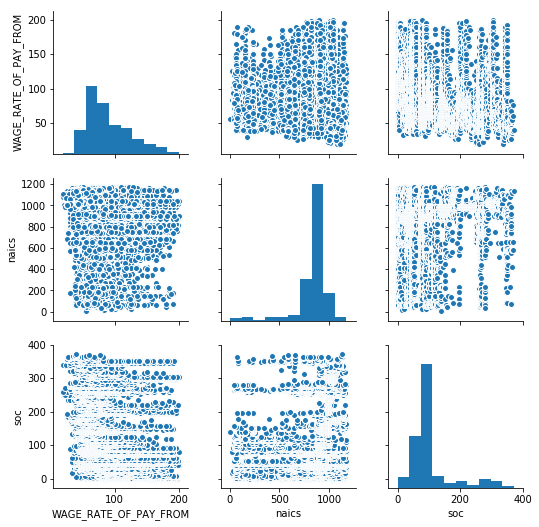

In [7]:
# plot data for New York
ny = sns.pairplot(myClusterNY[['WAGE_RATE_OF_PAY_FROM','naics','soc']])

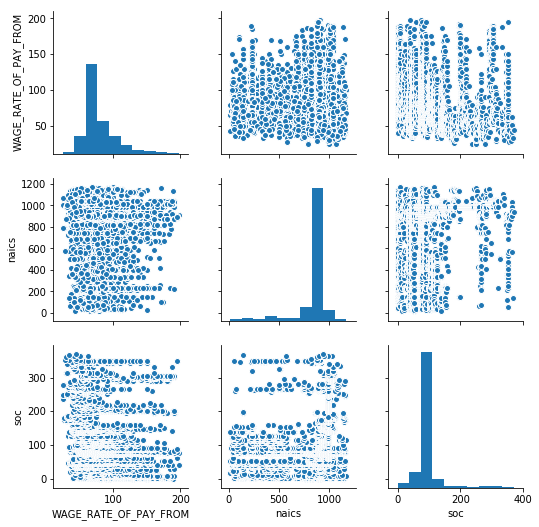

In [8]:
# plot data for Illinois
il = sns.pairplot(myClusterIL[['WAGE_RATE_OF_PAY_FROM','naics','soc']])

After getting the above graphs, we have a overview of the relationship between all these factors. We can also get the information of "where most of the data are" from the bar chart. For example, for graph 'il' - WAGE_RATE_OF_PAY_FROM vs WAGE_RATE_OF_PAY_FROM, we can see that most petitioners in the dataset earn salary between 50K to 100K. 

Further, we would like to know what is the most typical salary and it's corresponding occupation in a city. Therefore, we use cluster to plot the points.

#### Cluster (Wage vs Occupation)

Because the following code runs for a very long time (around an hour for each cluster graph), we would recommmend the markers to read the code, description and result without running the code.

In the following codes, we are trying to find the most 3 typical combination of wage and occupation for NY, CA and IL. 

In [9]:
# prepare values (use sampling) for clustering on wages and SOC for each of the three states
dataCluster1 = myClusterCA.sample(frac=0.1)
dataCluster2 = myClusterNY.sample(frac=0.3)
dataCluster3 = myClusterIL.sample(frac=0.3)
socwageCA = copy.deepcopy(dataCluster1[['soc','WAGE_RATE_OF_PAY_FROM']])
socwageNY = copy.deepcopy(dataCluster2[['soc','WAGE_RATE_OF_PAY_FROM']])
socwageIL = copy.deepcopy(dataCluster3[['soc','WAGE_RATE_OF_PAY_FROM']])
socwageCA.columns=[['Position Type - CA','Yearly Wage - CA']]
socwageNY.columns=[['Position Type - NY','Yearly Wage - NY']]
socwageIL.columns=[['Position Type - IL','Yearly Wage - IL']]
K = 3

# Create Initial Guess
muCA0 = [np.array((np.random.uniform(80, 110),
                   np.random.uniform(socwageCA['Yearly Wage - CA'].min(),
                                     socwageCA['Yearly Wage - CA'].max()))) for i in range(K)]
muNY0 = [np.array((np.random.uniform(60, 120),
                   np.random.uniform(socwageNY['Yearly Wage - NY'].min(),
                                     socwageNY['Yearly Wage - NY'].max()))) for i in range(K)]
muIL0 = [np.array((np.random.uniform(80, 110),
                   np.random.uniform(socwageIL['Yearly Wage - IL'].min(),
                                     socwageIL['Yearly Wage - IL'].max()))) for i in range(K)]

socwageCA['Cluster'] = 0
socwageCA = socwageCA.reset_index(drop=True)
socwageNY['Cluster'] = 0
socwageNY = socwageNY.reset_index(drop=True)
socwageIL['Cluster'] = 0
socwageIL = socwageIL.reset_index(drop=True)

/Users/Zhiyuan/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


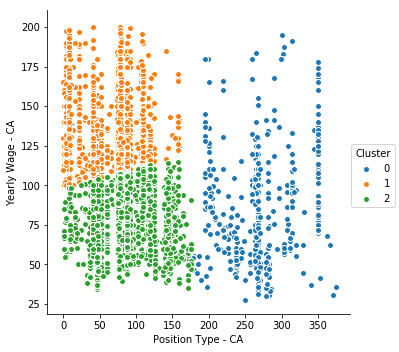

In [10]:
# Create clusters containing points closest in distance to each centroid (data for CA)
# Run LS cluster...(Use shorter loops and low precision to save time)
#### Run 60 minutes on OS-system i7 64bit machine ####
#diff, n = 1, 0
#while diff>.1 and n<5: 
#    n += 1
#    for i in socwageCA.index:
#        p=np.array((socwageCA['Position Type - CA'].iloc[i],socwageCA['Yearly Wage - CA'].iloc[i]))
#        d=np.array([np.linalg.norm(p-muCA0[k]) for k in range(K)])
#        bestKindex=np.argmin(d)
#        socwageCA['Cluster'].iloc[i]=bestKindex
#    muCA1= [np.array((socwageCA[socwageCA.Cluster==k]['Position Type - CA'].mean(),\
#            socwageCA[socwageCA.Cluster==k]['Yearly Wage - CA'].mean())) for k in range(K)]
#    diff=sum([np.linalg.norm(muCA1[k]-muCA0[k]) for k in range(K)])
#    muCA0 = muCA1
# plot
#sns.pairplot(x_vars=['Position Type - CA'], y_vars=['Yearly Wage - CA'], data=socwageCA, hue="Cluster", size=5)

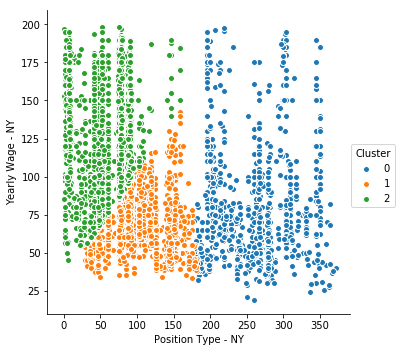

In [11]:
# Create clusters containing points closest in distance to each centroid (data for NY) 
# Run LS cluster...(Use shorter loops and low precision to save time)
#### Run 60 minutes on OS-system i7 64bit machine ####
#diff, n = 1, 0
#while diff>.1 and n<5: 
#    n += 1
#    for i in socwageNY.index:
#        p=np.array((socwageNY['Position Type - NY'].iloc[i],socwageNY['Yearly Wage - NY'].iloc[i]))
#        d=np.array([np.linalg.norm(p-muNY0[k]) for k in range(K)])
#        bestKindex=np.argmin(d)
#        socwageNY['Cluster'].iloc[i]=bestKindex
#    muNY1= [np.array((socwageNY[socwageNY.Cluster==k]['Position Type - NY'].mean(),\
#            socwageNY[socwageNY.Cluster==k]['Yearly Wage - NY'].mean())) for k in range(K)]
#    diff=sum([np.linalg.norm(muNY1[k]-muNY0[k]) for k in range(K)])
#    muNY0 = muNY1

# plot
#sns.pairplot(x_vars=['Position Type - NY'], y_vars=['Yearly Wage - NY'], data=socwageNY, hue="Cluster", size=5)

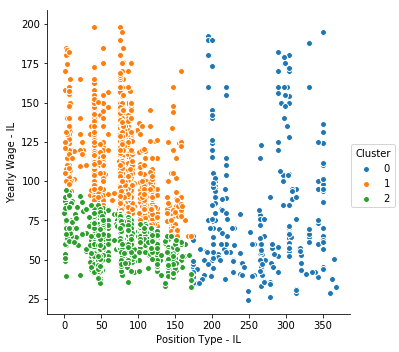

In [12]:
# Create clusters containing points closest in distance to each centroid (data for IL)
# Run LS cluster...(Use shorter loops and low precision to save time)
#### Run 60 minutes on OS-system i7 64bit machine ####
#diff, n = 1, 0
#while diff>.1 and n<5: 
#    n += 1
#    for i in socwageIL.index:
#        p=np.array((socwageIL['Position Type - IL'].iloc[i],socwageIL['Yearly Wage - IL'].iloc[i]))
#        d=np.array([np.linalg.norm(p-muIL0[k]) for k in range(K)])
#        bestKindex=np.argmin(d)
#        socwageIL['Cluster'].iloc[i]=bestKindex
#    muIL1= [np.array((socwageIL[socwageIL.Cluster==k]['Position Type - IL'].mean(),\
#            socwageIL[socwageIL.Cluster==k]['Yearly Wage - IL'].mean())) for k in range(K)]
#    diff=sum([np.linalg.norm(muIL1[k]-muIL0[k]) for k in range(K)])
#    muIL0 = muIL1

# plot
#sns.pairplot(x_vars=['Position Type - IL'], y_vars=['Yearly Wage - IL'], data=socwageIL, hue="Cluster", size=5)

The raw output of the points are as follows. We try to match the figure with their corresponding description, and return the descriptive output.

In [13]:
print "Cluster Centers for California:\n", muCA1

Cluster Centers for California:
[array([ 273.97787611,   87.75439867]), array([  74.75419982,  134.22117396]), array([ 81.73132577,  80.68222138])]


In [14]:
print "Cluster Centers for New York:\n", muNY1

Cluster Centers for New York:
[array([ 263.05793991,   81.49142054]), array([ 84.82126524,  67.91681666]), array([  62.57318343,  114.68688525])]


In [15]:
print "Cluster Centers for Illinois:\n", muIL1

Cluster Centers for Illinois:
[array([ 269.73699422,   80.34401462]), array([  78.78560189,  101.1038491 ]), array([ 77.60415329,  64.75436532])]


In [16]:
# record the SOC Code with explanation in dictionary
jobMatch = {11:'Management Occupations', 13:'Business and Financial Operations Occupations',15:'Computer and Mathematical Occupations',
           17:'Architecture and Engineering Occupations',19:'Life, Physical, and Social Science Occupations',21:'Community and Social Service Occupations',
           23:'Legal Occupations',25:'Education, Training, and Library Occupations',27:'Arts, Design, Entertainment, Sports, and Media Occupations',
           29:'Healthcare Practitioners and Technical Occupations',31:'Healthcare Support Occupations',33:'Protective Service Occupations',
           35:'Food Preparation and Serving Related Occupations',37:'Building and Grounds Cleaning and Maintenance Occupations',
           39:'Personal Care and Service Occupations',41:'Sales and Related Occupations',43:'Office and Administrative Support Occupations',
           45:'Farming, Fishing, and Forestry Occupations',47:'Construction and Extraction Occupations',49:'Installation, Maintenance, and Repair Occupations',
           51:'Production Occupations',53:'Transportation and Material Moving Occupations'}

In [17]:
# Print out the three characteristic job for California
ca1, ca2, ca3 = muCA1[0], muCA1[1], muCA1[2]
capoint = []
for i in [ca1, ca2, ca3]:
     capoint.append((jobMatch[int(str(myClusterCA[myClusterCA['soc']-int(i[0])<=1]['SOC_CODE'].mode()[0])[:2])], str(i[1])+'k'))
print capoint        

[('Computer and Mathematical Occupations', '87.7543986726k'), ('Computer and Mathematical Occupations', '134.221173958k'), ('Computer and Mathematical Occupations', '80.6822213766k')]


In [18]:
# Print out the three characteristic job for New York State
ny1, ny2, ny3 = muNY1[0], muNY1[1], muNY1[2]
nypoint = []
for i in [ny1, ny2, ny3]:
    nypoint.append((jobMatch[int(str(myClusterNY[myClusterNY['soc']-int(i[0])<=1]['SOC_CODE'].mode()[0])[:2])], str(i[1])+'k'))
print nypoint    

[('Computer and Mathematical Occupations', '81.4914205365k'), ('Computer and Mathematical Occupations', '67.9168166616k'), ('Business and Financial Operations Occupations', '114.686885253k')]


In [19]:
# Print out the three characteristic job for Illinois State
il1, il2, il3 = muIL1[0], muIL1[1], muIL1[2]
ilpoint = []
for i in [il1, il2, il3]:
    ilpoint.append((jobMatch[int(str(myClusterIL[myClusterIL['soc']-int(i[0])<=1]['SOC_CODE'].mode()[0])[:2])], str(i[1])+'k'))
print ilpoint   

[('Computer and Mathematical Occupations', '80.3440146243k'), ('Computer and Mathematical Occupations', '101.103849099k'), ('Computer and Mathematical Occupations', '64.7543653179k')]


By using the above codes, we can identify the typical jobs with wage for different states. Users can use these information to get an overview of the job market.